# Machine Learning Project 2022: Plankton

### Authors:
- Bram Fresen
- Bram Huis
- Max Burger
- Moos Middelkoop

For the Machine Learning Project to finish off the minor Artificial Intelligence, we chose to tackle the plankton problem, originally uploaded as the United States national data science bowl in december 2014. For this problem, the goal is to classify microscopic images of particles in water as one of 121 different classes of plankton. The dataset is 30.000 images large, with varying sizes. The dataset is also imbalanced.

In order to solve this problem we will make use of a Convolutional Neural Network using the tensorflow library.

## Import libraries

Firstly, we will import the needed libraries, and check if we are running on a GPU.

In [1]:
import tensorflow as tf
import numpy as np
import cv2
import os
import random
import matplotlib.pyplot as plt
import math

from PIL import Image
from tensorflow.keras import layers, models, preprocessing
from sklearn.model_selection import train_test_split

print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Loading the training data, training labels and test data

We use the cv2 library to load the training images (which are .jpg files), and turn them into arrays. This piece of code was found online:

https://stackoverflow.com/questions/30230592/loading-all-images-using-imread-from-a-given-folder
https://drive.google.com/file/d/1hAaPzDMVEZ8X1tfRS2ieFEqi0R7Ww7uL/view

### Test data

The test data is unlabeled, so we can't use it for our own training, we can only try to predict the classes and submit our solution to kaggle to see how we did. We will probably not use this data much

In [2]:
# Create an empty list for the test data
test_data = []

# Path to folder for the test data
folder_test = 'data/test'

# Loop through the images, read them in and add them to a list
for image in os.listdir(folder_test):
    img = cv2.imread(os.path.join(folder_test, image))
    test_data.append(img)

### Training data

In [3]:
# Create empty lists for the not resized training data and then labels (not one hot encoded yet)
train_data = []
train_labels = []

# Create a folder path of the different categories
folder_train = 'data/train'

# Loop through the index (for the one hot matrix) and the categories
for number, categories in enumerate(os.listdir(folder_train)):
    
    # Loop through the images , read them in and add them to a list, also add the index 'number' to 
    # a list for the one hot matrix
    for image in os.listdir(f'data/train/{categories}'):
        train_labels.append(number)
        img = cv2.imread(os.path.join(f'data/train/{categories}', image))
        train_data.append(img)

# Create a one hot matrix from the train labels
train_labels_one_hot = tf.keras.utils.to_categorical(train_labels)

### There are 3 channels in each of the images. The cell below shows that each of the channels have the same values (test 1 and 2). Test 3 and 4 are here to show that the 'np.array_equal' function works; the values from different images return a false.

In [50]:
x = train_data[0]
y = train_data[1]

a0 = x[:, :, 0]
b0 = x[:, :, 1]
c0 = x[:, :, 2]

a1 = y[:, :, 0]
b1 = y[:, :, 1]
c1 = y[:, :, 2]

test_1 = np.array_equal(a0, b0)
test_2 = np.array_equal(b0, c0)

test_3 = np.array_equal(a0, a1)
test_4 = np.array_equal(b0, c1)


print(f' Test 1: {test_1}, Test 2: {test_2}')
print(f' Test 3: {test_3}, Test 4: {test_4}')

 Test 1: True, Test 2: True
 Test 3: False, Test 4: False


# Resize input images

Average dimensions: 66.66182093881856, 73.50728507383967
Lowest first dimension image (21, 71, 3)
Lowest second dimension image (31, 49, 3)


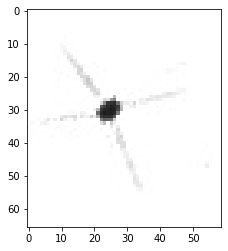

In [51]:
# Start with an infinitely large number
value_1 = math.inf
value_2 = math.inf
sum_1 = 0
sum_2 = 0
count = 0

# This checks for the lowest image size in the first and second dimension
for image in train_data:
    count+=1
    sum_1 += image.shape[0]
    sum_2 += image.shape[1]
    if image.shape[0] < value_1:
        
        value_1 = image.shape[0]
        hold_1 = image.shape
    if image.shape[1] < value_2:
        
        value_2 = image.shape[0]
        hold_2 = image.shape
        
sum_11 = sum_1 / count
sum_22 = sum_2 / count

print(f'Average dimensions: {sum_11}, {sum_22}')

plt.imshow(train_data[0])

print(f'Lowest first dimension image {hold_1}')
print(f'Lowest second dimension image {hold_2}')

(28, 28, 3)


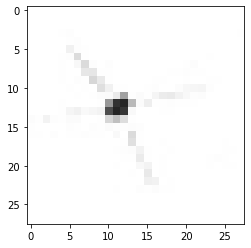

In [52]:
# Create an empty list for the training data
train_data_resized = []

# Loop through the images in the training data and resize them to the lowest shape in the dataset, 
# then append the image to the 'train_data_resized' list
for image in train_data:
    img = cv2.resize(image, (28, 28))
    train_data_resized.append(img)

# Test if the image is resized and show the image
print(train_data_resized[0].shape)
plt.imshow(train_data_resized[0])

#Split the data into 70% training and 30% validation
im_train, im_val, lab_train, lab_val = train_test_split(train_data_resized, train_labels_one_hot, train_size=0.7, random_state=1265599650)

In [53]:
# Convert the data to numpy arrays, so tensorflow can use them
image_train = np.array(im_train)
label_train = np.array(lab_train)
image_val = np.array(im_val)
label_val = np.array(lab_val)

# Test if the shapes are correct
print(image_train.shape)
print(label_train.shape)
print(image_val.shape)
print(label_val.shape)

(21235, 28, 28, 3)
(21235, 121)
(9101, 28, 28, 3)
(9101, 121)


## Convolutional network

We use the function 'train_and_evaluate' which, obviously, trains our model and then evaluates the trained model on the validation data. This function was reused from the CIFAR-assignment from module 6 of ML2.

In [19]:
def train_and_evaluate(model, train_x, train_y, val_x, val_y, preprocess={}, epochs=20, augment={}):
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    train_gen = preprocessing.image.ImageDataGenerator(**preprocess, **augment)
    train_gen.fit(train_x) 

    val_gen = preprocessing.image.ImageDataGenerator(**preprocess)
    val_gen.fit(train_x)

    history = model.fit(train_gen.flow(train_x, train_y), epochs=epochs, 
                        validation_data=val_gen.flow(val_x, val_y))

    fig, axs = plt.subplots(1,2,figsize=(20,5)) 

    for i, metric in enumerate(['loss', 'accuracy']):
        axs[i].plot(history.history[metric])
        axs[i].plot(history.history['val_'+metric])
        axs[i].legend(['training', 'validation'], loc='best')

        axs[i].set_title('Model '+metric)
        axs[i].set_ylabel(metric)
        axs[i].set_xlabel('epoch')

    plt.show()

    print(f"Validation Accuracy: {model.evaluate(val_gen.flow(val_x, val_y))[1]}")

## The actual model

We start with a very simple convolutional neural network, with 2 convolutional layers, both with pooling afterwards, and one dense layer. kernelsize, amount of filters, amount of nodes are specified in the code cell.

ERROR! Session/line number was not unique in database. History logging moved to new session 573
  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


  ...
    to  
  ['...']


Train for 664 steps, validate for 285 steps
Epoch 1/20
664/664 [==============================] - 3s 5ms/step - loss: 4.3906 - accuracy: 0.2478 - val_loss: 2.5467 - val_accuracy: 0.3491
Epoch 2/20
664/664 [==============================] - 2s 3ms/step - loss: 2.3205 - accuracy: 0.3899 - val_loss: 2.2715 - val_accuracy: 0.4045
Epoch 3/20
664/664 [==============================] - 2s 4ms/step - loss: 2.0469 - accuracy: 0.4492 - val_loss: 2.1091 - val_accuracy: 0.4426
Epoch 4/20
664/664 [==============================] - 2s 3ms/step - loss: 1.8583 - accuracy: 0.4852 - val_loss: 2.0216 - val_accuracy: 0.4672
Epoch 5/20
664/664 [==============================] - 2s 3ms/step - loss: 1.7347 - accuracy: 0.5102 - val_loss: 2.0064 - val_accuracy: 0.4730
Epoch 6/20
664/664 [==============================] - 2s 3ms/step - loss: 1.6155 - accuracy: 0.5378 - val_loss: 1.9555 - val_accuracy: 0.5004
Epoch 7/20
664/664 [==============================] - 2s 3ms/step - loss: 1.5115 - accuracy: 0.5644 - va

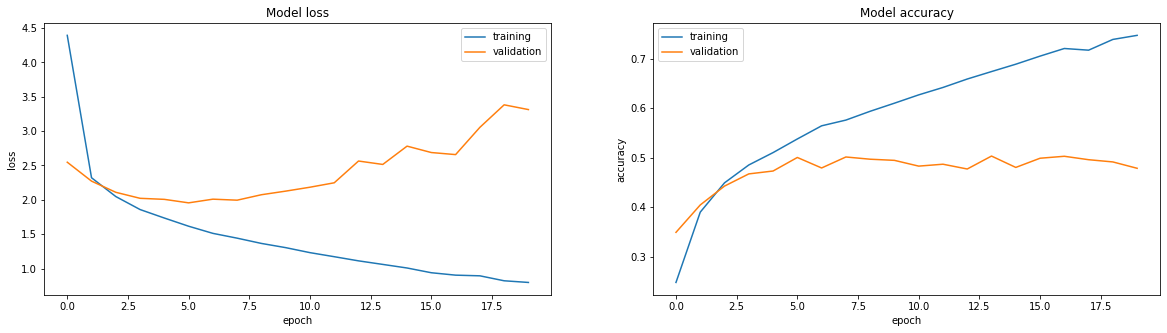

  ...
    to  
  ['...']


  ...
    to  
  ['...']


285/285 [==============================] - 0s 2ms/step - loss: 3.3131 - accuracy: 0.4785
Validation Accuracy: 0.47851884365081787


In [20]:
first_layer_filters = 32
second_layer_filters = 64
kernelsize = (3,3)
inputshape = (28,28,3)
first_hidden_layer_nodes = 128
output_nodes = 121

model_1 = models.Sequential()

model_1.add(layers.Conv2D(first_layer_filters, kernelsize, activation = 'relu', padding = 'same', input_shape = inputshape))
model_1.add(layers.MaxPooling2D((2, 2)))
model_1.add(layers.Conv2D(second_layer_filters, kernelsize, activation = 'relu', padding = 'same', input_shape = inputshape))
model_1.add(layers.MaxPooling2D((2, 2)))

model_1.add(layers.Flatten())
model_1.add(layers.Dense(first_hidden_layer_nodes, activation = 'relu'))
model_1.add(layers.Dense(output_nodes, activation = 'softmax'))

train_and_evaluate(model_1, image_train, label_train, image_val, label_val, epochs = 20)